# Neural Networks (Deep Learning)
A family of algorithms known as neural networks has recently seen a revival under the name “deep learning.” While deep learning shows great promise in many machine learning applications, deep learning algorithms are often tailored very carefully to a specific use case. Here, we will only discuss some relatively simple methods, namely *multilayer perceptrons* for classification and regression, that can serve as a starting point for more involved deep learning methods. Multilayer perceptrons (MLPs) are also known as (vanilla) feed-forward neural networks, or sometimes just neural networks.

*Disclaimer*: Much of the code in this notebook was lifted from the excellent book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Andreas Muller and Sarah Guido.

## The neural network model
MLPs can be viewed as generalizations of linear models that perform multiple stages of processing to come to a decision.
Remember that the prediction by a linear regressor is given as:

    ŷ = w[0] * x[0] + w[1] * x[1] + ... + w[p] * x[p] + b
In plain English, ŷ is a weighted sum of the input features x[0] to x[p], weighted by the learned coefficients w[0] to w[p].

In an MLP this process of computing weighted sums is repeated multiple times, first computing hidden units that represent an intermediate processing step, which are again combined using weighted sums to yield the final result.

This model has a lot more coefficients (also called weights) to learn than a simple linear model: there is one between every input and every hidden unit (which make up the hidden layer), and one between every unit in the hidden layer and the output.

Computing a series of weighted sums is mathematically the same as computing just one weighted sum, so to make this model truly more powerful than a linear model, we need one extra trick. After computing a weighted sum for each hidden unit, a nonlinear function is applied to the result—usually the *rectifying nonlinearity* (also known as rectified linear unit or relu), the *tangens hyperbolicus* (tanh), or the *sigmoid* (also called the *logistic* function). The result of this function is then used in the weighted sum that computes the output, ŷ. The relu cuts off values below zero, while tanh saturates to –1 for low input values and +1 for high input values, and sigmoid saturates to 0 for low input values and +1 for high input values. Any of these nonlinear functions allows the neural network to learn much more complicated functions than a linear model could.  Below is a plot of these three nonlinear functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

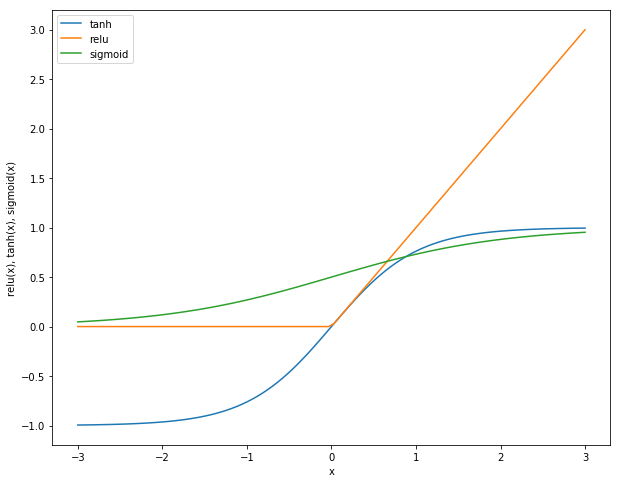

In [4]:
from scipy.special import expit

line = np.linspace(-3, 3, 100)
plt.figure(figsize=(10,8))
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.plot(line, expit(line), label='sigmoid')
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x), sigmoid(x)")

For a small neural network with a single hidden layer with three nodes, the full formula for computing ŷ in the case of regression would be (when using a tanh nonlinearity):

    h[0] = tanh(w[0, 0] * x[0] + w[1, 0] * x[1] + w[2, 0] * x[2] + w[3, 0] * x[3])
    h[1] = tanh(w[0, 0] * x[0] + w[1, 0] * x[1] + w[2, 0] * x[2] + w[3, 0] * x[3])
    h[2] = tanh(w[0, 0] * x[0] + w[1, 0] * x[1] + w[2, 0] * x[2] + w[3, 0] * x[3])
    ŷ = v[0] * h[0] + v[1] * h[1] + v[2] * h[2]
Here, w are the weights between the input x and the hidden layer h, and v are the weights between the hidden layer h and the output ŷ. The weights v and w are learned from data, x are the input features, ŷ is the computed output, and h are intermediate computations. An important parameter that needs to be set by the user is the number of nodes in the hidden layer. This can be as small as 10 for very small or simple datasets and as big as 10,000 for very complex data. It is also possible to add additional hidden layers.

Having large neural networks made up of many of these layers of computation is what inspired the term “deep learning.”

## Advantages of Neural Networks
* Able to capture information contained in large amounts of data and build incredibly complex models
* Given enough computation time, data, and careful tuning of the parameters, neural networks often beat other machine learning algorithms (for classification and regression tasks)

## Disadvantages of Neural Networks
* Neural networks—particularly the large and powerful ones—often take a long time to train
* Require careful preprocessing of the data
* They work best with “homogeneous” data, where all the features have similar meanings
    * For data that has very different kinds of features, tree-based models might work better
* Tuning neural network parameters is an art and generally more complex than tuning parameters for other algorithms

# Neural Networks in scikit-learn
Recent versions of *scikit-learn* have added rudimentary support for neural networks.  The implementation in *scikit-learn* is not intended for large-scale applications. In particular, *scikit-learn* offers no GPU support.  For much faster, GPU-based implementations, as well as frameworks offering much more flexibility to build deep learning architectures, see either [Tensorflow](https://www.tensorflow.org/), [Theano](http://deeplearning.net/software/theano/), or [Keras](https://keras.io/).  Using *Tensorflow* will be covered below.

### Advantage of MLP
* Capability to learn non-linear models
* Capability to learn models in real-time (on-line learning) using *partial_fit*

### Disadvantages of MLP
* MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
* MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
* MLP is sensitive to feature scaling.

scikit-learn has support for Multi-layer Perceptron (MLP) networks only. The [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and [MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) for regression, classes in the *neural_network* module deal with classification and regression, respectively.

## Tuning neural networks
Let’s look into the workings of the MLP by applying the MLPClassifier on a synthetic dataset.

*scikit-learn* has the [make_moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons) function in the *datasets* module for creating a toy dataset consisting of two interleaving half circles for use with clustering and classification algorithms.

This can create a nice dataset for classification problems because the groups created are generally not linearly seperable.

In [16]:
# Helper function for classification plots
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1, linewidth=None, threshold=None, linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape), levels=fill_levels, alpha=alpha)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [23]:
# Helper function for classification plots
import matplotlib as mpl
from matplotlib.colors import colorConverter
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines


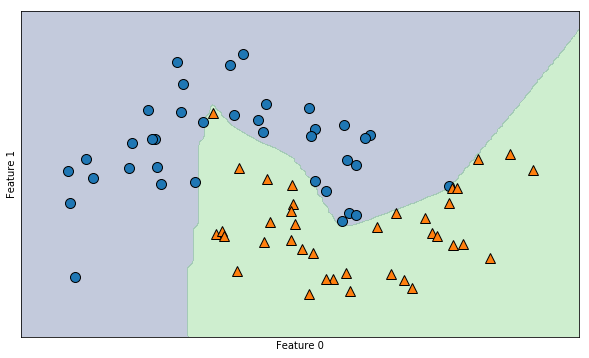

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=[100], activation='relu', solver='lbfgs', random_state=0).fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

As you can see, the neural network learned a very nonlinear but relatively smooth decision boundary. We used *solver='lbfgs'*, which we will discuss later.

By default, the MLP uses 100 hidden nodes, which is quite a lot for this small dataset. We can reduce the number (which reduces the complexity of the model) and still get a good result:

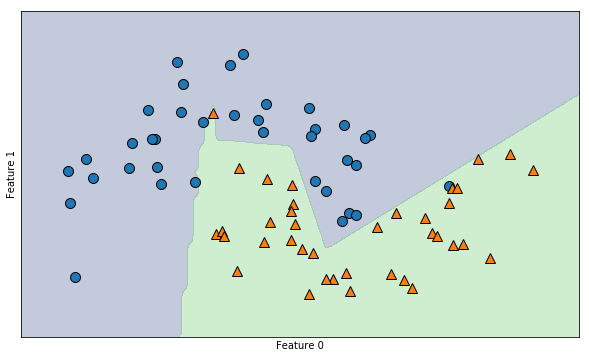

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=[10], activation='relu', solver='lbfgs', random_state=0).fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

With only 10 hidden units, the decision boundary looks somewhat more ragged. The default nonlinearity is relu, shown above. With a single hidden layer, this means the decision function will be made up of 10 straight line segments. If we want a smoother decision boundary, we could add more hidden units, as shown two figures above, add a second hidden layer, or use the tanh or logistic nonlinearity:

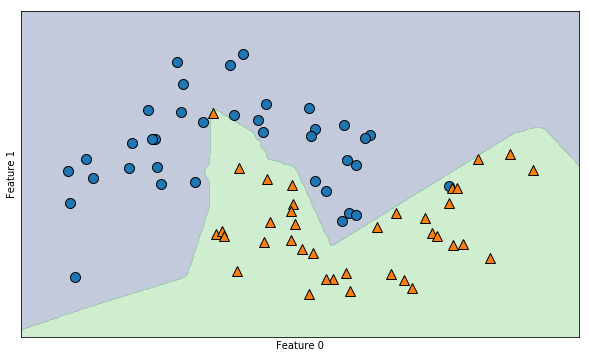

In [29]:
# using two hidden layers, with 10 units each
mlp = MLPClassifier(hidden_layer_sizes=[10, 10], activation='relu', solver='lbfgs', random_state=0).fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

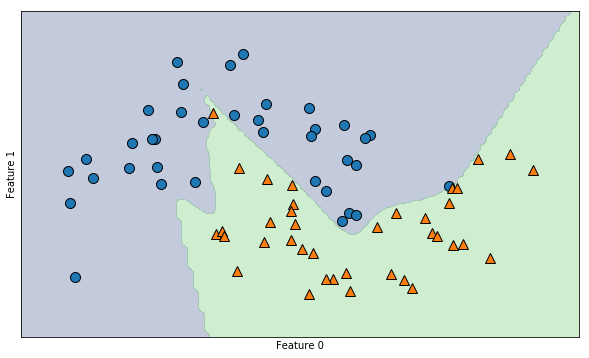

In [30]:
# using two hidden layers, with 10 units each, now with tanh nonlinearity
# using two hidden layers, with 10 units each
mlp = MLPClassifier(hidden_layer_sizes=[10, 10], activation='tanh', solver='lbfgs', random_state=0).fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Finally, we can also control the complexity of a neural network by using an l2 penalty to shrink the weights toward zero, as we did in ridge regression and the linear classifiers. The parameter for this in the **MLPClassifier** is **alpha** (as in the linear regression models), and it’s set to a very low value (little regularization) by default. The figure below shows the effect of different values of alpha on the two_moons dataset, using two hidden layers of 10 or 100 units each:

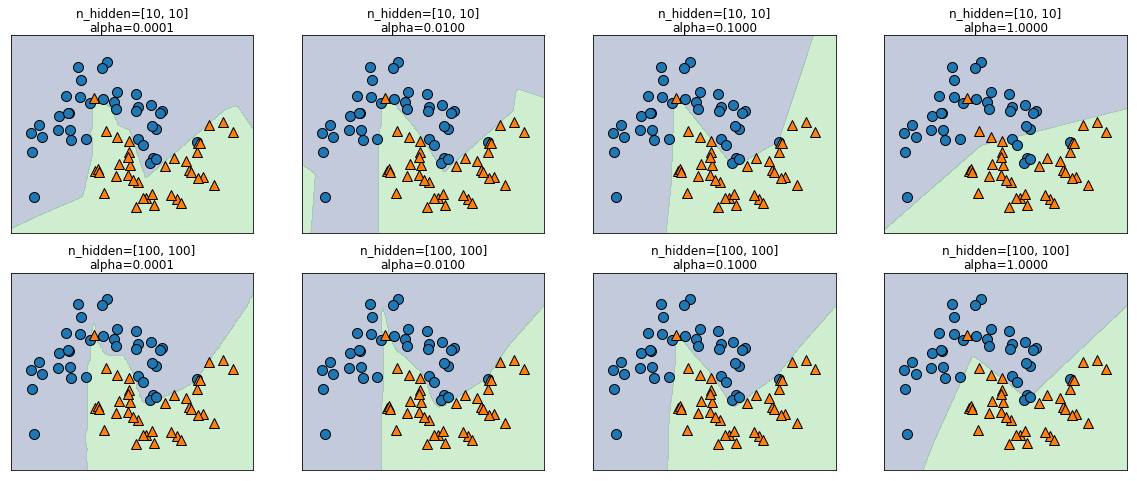

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes], activation='relu', solver='lbfgs', 
                            alpha=alpha, random_state=0)
        mlp.fit(X_train, y_train)
        plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        ax.set_title("n_hidden=[{}, {}]\nalpha={:.4f}".format(n_hidden_nodes, n_hidden_nodes, alpha))

As you probably have realized by now, there are many ways to control the complexity of a neural network: the number of hidden layers, the number of units in each hidden layer, and the regularization (alpha). There are actually even more, which we won’t go into here.

An important property of neural networks is that their weights are set randomly before learning is started, and this random initialization affects the model that is learned. That means that even when using exactly the same parameters, we can obtain very different models when using different random seeds. If the networks are large, and their complexity is chosen properly, this should not affect accuracy too much, but it is worth keeping in mind (particularly for smaller networks). The figure below shows plots of several models, all learned with the same settings of the parameters:

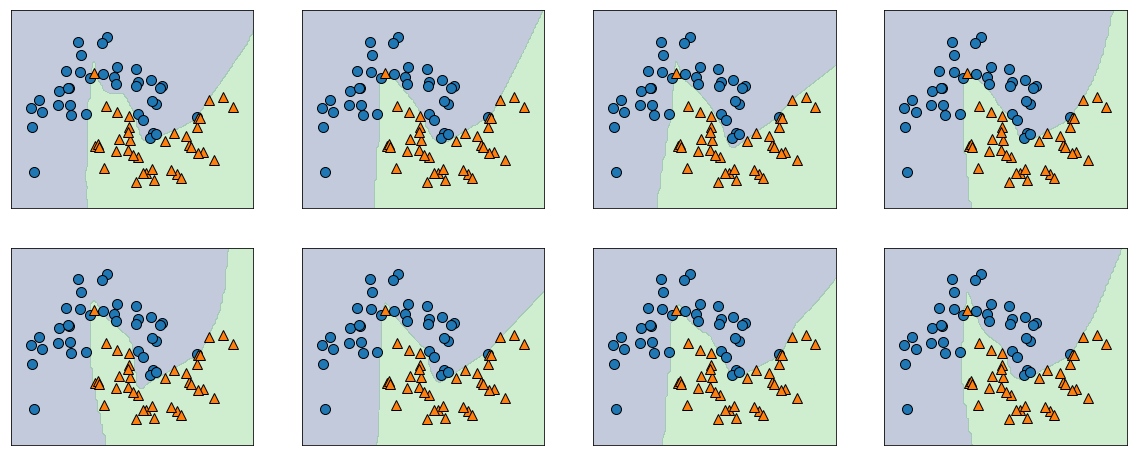

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, ax in enumerate(axes.ravel()):
    mlp = MLPClassifier(hidden_layer_sizes=[100, 100], solver='lbfgs', random_state=i)
    mlp.fit(X_train, y_train)
    plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
    discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)

To get a better understanding of neural networks on real-world data, let’s apply the **MLPClassifier** to the Breast Cancer dataset which is built into *scikit-learn*. We start with the default parameters:

In [33]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("Cancer data per-feature maxima:\n{}".format(cancer.data.max(axis=0)))

Cancer data per-feature maxima:
[  2.81100000e+01   3.92800000e+01   1.88500000e+02   2.50100000e+03
   1.63400000e-01   3.45400000e-01   4.26800000e-01   2.01200000e-01
   3.04000000e-01   9.74400000e-02   2.87300000e+00   4.88500000e+00
   2.19800000e+01   5.42200000e+02   3.11300000e-02   1.35400000e-01
   3.96000000e-01   5.27900000e-02   7.89500000e-02   2.98400000e-02
   3.60400000e+01   4.95400000e+01   2.51200000e+02   4.25400000e+03
   2.22600000e-01   1.05800000e+00   1.25200000e+00   2.91000000e-01
   6.63800000e-01   2.07500000e-01]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.91
Accuracy on test set: 0.88


The accuracy of the MLP is quite good, but not as good as some other models.  This is likely due to scaling of the data. Neural networks expect all input features to vary in a similar way, and ideally to have a mean of 0, and a variance of 1. We must rescale our data so that it fulfills these requirements. We can do this using semi-automatically using the **StandardScaler**.

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.965


C:\Users\SiUser\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


The results are much better after scaling, and already quite competitive. We got a warning from the model, though, that tells us that the maximum number of iterations has been reached. This is part of the default *adam* solver for learning the model, and tells us that we should increase the number of iterations:

In [46]:
mlp = MLPClassifier(max_iter=250, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.993
Accuracy on test set: 0.972


Increasing the number of iterations only slightly increased the training and generalization performance. Still, the model is performing quite well. As there is some gap between the training and the test performance, we might try to decrease the model’s complexity to get better generalization performance. Here, we choose to increase the **alpha** parameter (quite aggressively, from 0.0001 to 1) to add stronger regularization of the weights:

In [48]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


This didn't help, but the performance is already excellent.

While it is possible to analyze what a neural network has learned, this is usually much trickier than analyzing a linear model or a tree-based model.

While the **MLPClassifier** and **MLPRegressor** provide easy-to-use interfaces for the most common neural network architectures, they only capture a small subset of what is possible with neural networks. If you are interested in working with more flexible or larger models,you need to look beyond *scikit-learn* into the fantastic deep learning libraries that are out there. For Python users, the most well-established are keras, lasagna, and tensor-flow. lasagna builds on the theano library, while keras can use either tensor-flow or theano. These libraries provide a much more flexible interface to build neural networks and track the rapid progress in deep learning research. All of the popular deep learning libraries also allow the use of high-performance graphics processing units (GPUs), which scikit-learn does not support. Using GPUs allows us to accelerate computations by factors of 10x to 100x, and they are essential for applying deep learning methods to large-scale datasets.